### 天猫复购预测之挑战
https://tianchi.aliyun.com/competition/entrance/231576/

In [1]:
%%time
import gc
import pandas as pd
# 用户行为，使用format1进行加载
# 加载全量样本

user_log = pd.read_csv('./data_format1/user_log_format1.csv', dtype={'time_stamp':'str'})
user_info = pd.read_csv('./data_format1/user_info_format1.csv')
train_data1 = pd.read_csv('./data_format1/train_format1.csv')
submission = pd.read_csv('./data_format1/test_format1.csv')
train_data = pd.read_csv('./data_format2/train_format2.csv')
"""
# 加载小样本
user_log = pd.read_csv('./data_format1_small/sample_user_log.csv', dtype={'time_stamp':'str'})
user_info = pd.read_csv('./data_format1_small/sample_user_info.csv')
train_data1 = pd.read_csv('./data_format1_small/train.csv')
submission = pd.read_csv('./data_format1_small/test.csv')
train_data = pd.read_csv('./data_format2/train_format2.csv')
"""

Wall time: 59.5 s


"\n# 加载小样本\nuser_log = pd.read_csv('./data_format1_small/sample_user_log.csv', dtype={'time_stamp':'str'})\nuser_info = pd.read_csv('./data_format1_small/sample_user_info.csv')\ntrain_data1 = pd.read_csv('./data_format1_small/train.csv')\nsubmission = pd.read_csv('./data_format1_small/test.csv')\ntrain_data = pd.read_csv('./data_format2/train_format2.csv')\n"

In [2]:
%%time
train_data1['origin'] = 'train'
submission['origin'] = 'test'
matrix = pd.concat([train_data1, submission], ignore_index=True, sort=False)
print(matrix)

        user_id  merchant_id  label origin  prob
0         34176         3906    0.0  train   NaN
1         34176          121    0.0  train   NaN
2         34176         4356    1.0  train   NaN
3         34176         2217    0.0  train   NaN
4        230784         4818    0.0  train   NaN
...         ...          ...    ...    ...   ...
522336   228479         3111    NaN   test   NaN
522337    97919         2341    NaN   test   NaN
522338    97919         3971    NaN   test   NaN
522339    32639         3536    NaN   test   NaN
522340    32639         3319    NaN   test   NaN

[522341 rows x 5 columns]
Wall time: 41.8 ms


In [3]:
%%time
matrix.drop(['prob'], axis=1, inplace=True)
# 连接user_info表，通过user_id关联
matrix = matrix.merge(user_info, on='user_id', how='left')
# 使用merchant_id（原列名seller_id）
user_log.rename(columns={'seller_id':'merchant_id'}, inplace=True)
# 格式化
user_log['user_id'] = user_log['user_id'].astype('int32')
user_log['merchant_id'] = user_log['merchant_id'].astype('int32')
user_log['item_id'] = user_log['item_id'].astype('int32')
user_log['cat_id'] = user_log['cat_id'].astype('int32')
user_log['brand_id'].fillna(0, inplace=True)
user_log['brand_id'] = user_log['brand_id'].astype('int32')
user_log['time_stamp'] = pd.to_datetime(user_log['time_stamp'], format='%H%M')
# 1 for <18; 2 for [18,24]; 3 for [25,29]; 4 for [30,34]; 5 for [35,39]; 6 for [40,49]; 7 and 8 for >= 50; 0 and NULL for unknown
matrix['age_range'].fillna(0, inplace=True)
# 0:female, 1:male, 2:unknown
matrix['gender'].fillna(2, inplace=True)
matrix['age_range'] = matrix['age_range'].astype('int8')
matrix['gender'] = matrix['gender'].astype('int8')
matrix['label'] = matrix['label'].astype('str')
matrix['user_id'] = matrix['user_id'].astype('int32')
matrix['merchant_id'] = matrix['merchant_id'].astype('int32')
del user_info, train_data1
gc.collect()
print(matrix)

        user_id  merchant_id label origin  age_range  gender
0         34176         3906   0.0  train          6       0
1         34176          121   0.0  train          6       0
2         34176         4356   1.0  train          6       0
3         34176         2217   0.0  train          6       0
4        230784         4818   0.0  train          0       0
...         ...          ...   ...    ...        ...     ...
522336   228479         3111   nan   test          6       0
522337    97919         2341   nan   test          8       1
522338    97919         3971   nan   test          8       1
522339    32639         3536   nan   test          0       0
522340    32639         3319   nan   test          0       0

[522341 rows x 6 columns]
Wall time: 11.9 s


In [4]:
%%time
# User特征处理
groups = user_log.groupby(['user_id'])
# 用户交互行为数量 u1
temp = groups.size().reset_index().rename(columns={0:'u1'})
matrix = matrix.merge(temp, on='user_id', how='left')
# 使用agg 基于列的聚合操作，统计唯一值的个数 item_id, cat_id, merchant_id, brand_id
#temp = groups['item_id', 'cat_id', 'merchant_id', 'brand_id'].nunique().reset_index().rename(columns={'item_id':'u2', 'cat_id':'u3', 'merchant_id':'u4', 'brand_id':'u5'})
# 对于每个user_id 不重复的item_id的数量 => u2
temp = groups['item_id'].agg([('u2', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')
# 对于每个user_id 不重复的cat_id的数量 => u3
temp = groups['cat_id'].agg([('u3', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')
temp = groups['merchant_id'].agg([('u4', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')
temp = groups['brand_id'].agg([('u5', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')


Wall time: 3min 29s


In [5]:
%%time
# 时间间隔特征 u6 按照小时
# 对于每个user_id 计算time_stamp的最小时间 => F_time, 最大时间max => L_time
temp = groups['time_stamp'].agg([('F_time', 'min'), ('L_time', 'max')]).reset_index()
temp['u6'] = (temp['L_time'] - temp['F_time']).dt.seconds/3600
matrix = matrix.merge(temp[['user_id', 'u6']], on='user_id', how='left')
# 统计操作类型为0，1，2，3的个数
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns={0:'u7', 1:'u8', 2:'u9', 3:'u10'})
matrix = matrix.merge(temp, on='user_id', how='left')
print(matrix)

        user_id  merchant_id label origin  age_range  gender    u1    u2  u3  \
0         34176         3906   0.0  train          6       0   451   256  45   
1         34176          121   0.0  train          6       0   451   256  45   
2         34176         4356   1.0  train          6       0   451   256  45   
3         34176         2217   0.0  train          6       0   451   256  45   
4        230784         4818   0.0  train          0       0    54    31  17   
...         ...          ...   ...    ...        ...     ...   ...   ...  ..   
522336   228479         3111   nan   test          6       0  2004  1173  71   
522337    97919         2341   nan   test          8       1    55    29  14   
522338    97919         3971   nan   test          8       1    55    29  14   
522339    32639         3536   nan   test          0       0    72    46  24   
522340    32639         3319   nan   test          0       0    72    46  24   

         u4   u5        u6      u7   u8

In [6]:
%%time
# 商家特征处理
groups = user_log.groupby(['merchant_id'])
# 商家被交互行为数量 m1
temp = groups.size().reset_index().rename(columns={0:'m1'})
matrix = matrix.merge(temp, on='merchant_id', how='left')
# 统计商家被交互的user_id, item_id, cat_id, brand_id 唯一值
temp = groups['user_id', 'item_id', 'cat_id', 'brand_id'].nunique().reset_index().rename(columns={'user_id':'m2', 'item_id':'m3', 'cat_id':'m4', 'brand_id':'m5'})
matrix = matrix.merge(temp, on='merchant_id', how='left')
# 统计商家被交互的action_type 唯一值
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns={0:'m6', 1:'m7', 2:'m8', 3:'m9'})
matrix = matrix.merge(temp, on='merchant_id', how='left')
# 按照merchant_id 统计随机负采样的个数
temp = train_data[train_data['label']==-1].groupby(['merchant_id']).size().reset_index().rename(columns={0:'m10'})
matrix = matrix.merge(temp, on='merchant_id', how='left')
print(matrix)

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


        user_id  merchant_id label origin  age_range  gender    u1    u2  u3  \
0         34176         3906   0.0  train          6       0   451   256  45   
1         34176          121   0.0  train          6       0   451   256  45   
2         34176         4356   1.0  train          6       0   451   256  45   
3         34176         2217   0.0  train          6       0   451   256  45   
4        230784         4818   0.0  train          0       0    54    31  17   
...         ...          ...   ...    ...        ...     ...   ...   ...  ..   
522336   228479         3111   nan   test          6       0  2004  1173  71   
522337    97919         2341   nan   test          8       1    55    29  14   
522338    97919         3971   nan   test          8       1    55    29  14   
522339    32639         3536   nan   test          0       0    72    46  24   
522340    32639         3319   nan   test          0       0    72    46  24   

         u4  ...     m1     m2    m3   

In [7]:
%%time
# 按照user_id, merchant_id分组
groups = user_log.groupby(['user_id', 'merchant_id'])
temp = groups.size().reset_index().rename(columns={0:'um1'}) #统计行为个数
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')
temp = groups['item_id', 'cat_id', 'brand_id'].nunique().reset_index().rename(columns={'item_id':'um2', 'cat_id':'um3', 'brand_id':'um4'}) #统计item_id, cat_id, brand_id唯一个数
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns={0:'um5', 1:'um6', 2:'um7', 3:'um8'})#统计不同action_type唯一个数
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')
temp = groups['time_stamp'].agg([('first', 'min'), ('last', 'max')]).reset_index()
temp['um9'] = (temp['last'] - temp['first']).dt.seconds/3600
temp.drop(['first', 'last'], axis=1, inplace=True)
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left') #统计时间间隔
print(matrix)

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


        user_id  merchant_id label origin  age_range  gender    u1    u2  u3  \
0         34176         3906   0.0  train          6       0   451   256  45   
1         34176          121   0.0  train          6       0   451   256  45   
2         34176         4356   1.0  train          6       0   451   256  45   
3         34176         2217   0.0  train          6       0   451   256  45   
4        230784         4818   0.0  train          0       0    54    31  17   
...         ...          ...   ...    ...        ...     ...   ...   ...  ..   
522336   228479         3111   nan   test          6       0  2004  1173  71   
522337    97919         2341   nan   test          8       1    55    29  14   
522338    97919         3971   nan   test          8       1    55    29  14   
522339    32639         3536   nan   test          0       0    72    46  24   
522340    32639         3319   nan   test          0       0    72    46  24   

         u4  ...   m10  um1  um2  um3  

In [8]:
%%time
#用户购买点击比
matrix['r1'] = matrix['u9']/matrix['u7'] 
#商家购买点击比
matrix['r2'] = matrix['m8']/matrix['m6'] 
#不同用户不同商家购买点击比
matrix['r3'] = matrix['um7']/matrix['um5']
matrix.fillna(0, inplace=True)
# # 修改age_range字段名称为 age_0, age_1, age_2... age_8
temp = pd.get_dummies(matrix['age_range'], prefix='age')
matrix = pd.concat([matrix, temp], axis=1)
temp = pd.get_dummies(matrix['gender'], prefix='g')
matrix = pd.concat([matrix, temp], axis=1)
matrix.drop(['age_range', 'gender'], axis=1, inplace=True)
print(matrix)

        user_id  merchant_id label origin    u1    u2  u3   u4   u5        u6  \
0         34176         3906   0.0  train   451   256  45  109  108  5.833333   
1         34176          121   0.0  train   451   256  45  109  108  5.833333   
2         34176         4356   1.0  train   451   256  45  109  108  5.833333   
3         34176         2217   0.0  train   451   256  45  109  108  5.833333   
4        230784         4818   0.0  train    54    31  17   20   19  5.166667   
...         ...          ...   ...    ...   ...   ...  ..  ...  ...       ...   
522336   228479         3111   nan   test  2004  1173  71  278  282  6.000000   
522337    97919         2341   nan   test    55    29  14   17   17  4.750000   
522338    97919         3971   nan   test    55    29  14   17   17  4.750000   
522339    32639         3536   nan   test    72    46  24   33   35  5.800000   
522340    32639         3319   nan   test    72    46  24   33   35  5.800000   

        ...  age_2  age_3  

In [9]:
%%time
# 分割训练数据和测试数据
train_data = matrix[matrix['origin'] == 'train'].drop(['origin'], axis=1)
test_data = matrix[matrix['origin'] == 'test'].drop(['label', 'origin'], axis=1)
train_X, train_y = train_data.drop(['label'], axis=1), train_data['label']
del temp, matrix
gc.collect()

Wall time: 26.4 s


12

In [36]:
%%time
# 使用机器学习工具
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
import xgboost as xgb
# 将训练集进行切分，20%用于验证
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, test_size=.3)

# 使用XGBoost
model = xgb.XGBClassifier(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.80, 
    eta=0.3,    
    seed=42    
)
model.fit(
    X_train, y_train,
    eval_metric='auc', eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=True,
    #早停法，如果auc在10epoch没有进步就stop
    early_stopping_rounds=10 
)


model.fit(X_train, y_train)


[0]	validation_0-auc:0.63613	validation_1-auc:0.63228
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.64775	validation_1-auc:0.63774
[2]	validation_0-auc:0.65592	validation_1-auc:0.64424
[3]	validation_0-auc:0.66021	validation_1-auc:0.64658
[4]	validation_0-auc:0.66465	validation_1-auc:0.65178
[5]	validation_0-auc:0.66558	validation_1-auc:0.65122
[6]	validation_0-auc:0.66677	validation_1-auc:0.65163
[7]	validation_0-auc:0.66687	validation_1-auc:0.65272
[8]	validation_0-auc:0.66842	validation_1-auc:0.65474
[9]	validation_0-auc:0.66825	validation_1-auc:0.65485
[10]	validation_0-auc:0.66990	validation_1-auc:0.65549
[11]	validation_0-auc:0.67090	validation_1-auc:0.65571
[12]	validation_0-auc:0.67323	validation_1-auc:0.65819
[13]	validation_0-auc:0.67513	validation_1-auc:0.65830
[14]	validation_0-auc:0.67885	validation_1-auc:0.66166
[15]	validation_0-auc:0.6800

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=8,
              min_child_weight=300, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=42, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [11]:
%%time
prob = model.predict_proba(test_data)
submission['prob'] = pd.Series(prob[:,1])
submission.drop(['origin'], axis=1, inplace=True)
submission.to_csv('prediction.csv', index=False)

Wall time: 1.31 s


In [33]:
import lightgbm as lgb
# 使用LightGBM
model2 = lgb.LGBMClassifier(num_leaves=37, learning_rate=0.10, n_estimators=1000\
                    ,bagging_fraction=0.75,feature_fraction=0.75,seed=42    )
model2.fit(
    X_train, y_train,
    eval_metric='auc', eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=True,
    #早停法，如果auc在10epoch没有进步就stop
    early_stopping_rounds=10 
)


model2.fit(X_train, y_train)

[1]	training's auc: 0.627828	training's binary_logloss: 0.229111	valid_1's auc: 0.623636	valid_1's binary_logloss: 0.226164
Training until validation scores don't improve for 10 rounds
[2]	training's auc: 0.644398	training's binary_logloss: 0.227507	valid_1's auc: 0.640902	valid_1's binary_logloss: 0.22478
[3]	training's auc: 0.652657	training's binary_logloss: 0.226119	valid_1's auc: 0.647769	valid_1's binary_logloss: 0.223643
[4]	training's auc: 0.655096	training's binary_logloss: 0.225071	valid_1's auc: 0.649554	valid_1's binary_logloss: 0.22274
[5]	training's auc: 0.658443	training's binary_logloss: 0.224184	valid_1's auc: 0.652052	valid_1's binary_logloss: 0.222084
[6]	training's auc: 0.660251	training's binary_logloss: 0.223431	valid_1's auc: 0.652372	valid_1's binary_logloss: 0.221521
[7]	training's auc: 0.663818	training's binary_logloss: 0.222687	valid_1's auc: 0.654637	valid_1's binary_logloss: 0.220909
[8]	training's auc: 0.666175	training's binary_logloss: 0.222059	valid_1'

[68]	training's auc: 0.746077	training's binary_logloss: 0.206762	valid_1's auc: 0.676543	valid_1's binary_logloss: 0.215719
[69]	training's auc: 0.746778	training's binary_logloss: 0.206624	valid_1's auc: 0.676599	valid_1's binary_logloss: 0.215713
[70]	training's auc: 0.747355	training's binary_logloss: 0.206462	valid_1's auc: 0.676446	valid_1's binary_logloss: 0.215732
[71]	training's auc: 0.748089	training's binary_logloss: 0.2063	valid_1's auc: 0.676356	valid_1's binary_logloss: 0.215747
[72]	training's auc: 0.74878	training's binary_logloss: 0.206171	valid_1's auc: 0.676364	valid_1's binary_logloss: 0.215744
[73]	training's auc: 0.749795	training's binary_logloss: 0.205943	valid_1's auc: 0.677491	valid_1's binary_logloss: 0.215627
[74]	training's auc: 0.750407	training's binary_logloss: 0.205783	valid_1's auc: 0.677565	valid_1's binary_logloss: 0.215613
[75]	training's auc: 0.751519	training's binary_logloss: 0.205625	valid_1's auc: 0.677432	valid_1's binary_logloss: 0.215634
[76

LGBMClassifier(bagging_fraction=0.75, boosting_type='gbdt', class_weight=None,
               colsample_bytree=1.0, feature_fraction=0.75,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=37, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [21]:
%%time
prob2 = model2.predict_proba(test_data)
submission['prob'] = pd.Series(prob2[:,1])
submission.to_csv('prediction_lgb.csv', index=False)

Wall time: 3.89 s


In [22]:
prob_mean = prob*1/2 + prob2*1/2

In [23]:
%%time
submission['prob'] = pd.Series(prob_mean[:,1])
submission.to_csv('prediction_lgb_xgb.csv', index=False)

Wall time: 715 ms


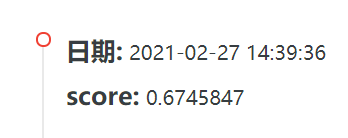